In [1]:
from __future__ import print_function
 
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,GRU,Conv1D, MaxPooling1D,SpatialDropout1D
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from keras.models import model_from_json
import numpy as np
import json
import requests
import pandas as pd

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df_all = pd.read_csv('data/19999_question_category_a_v16.csv')
print(f"df_all shape : {df_all.shape}")

df_all shape : (14247, 8)


In [3]:
mapping = df_all.category.astype('category').cat.categories
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [4]:
from NLP_JiebaSegmentor import JiebaSegmentor
jieba_dict_path1 = "jieba/dict_taiwan.txt"
jieba_dict_path2 = "jieba/userdict.txt"
jieba_dict_path3 = "jieba/dict.txt.big"
jieba_dict_path4 = "jieba/dict.txt.small"
jieba_dict_path5 = "jieba/dict_system.txt"
jieba_stopwords_path = "jieba/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[jieba_dict_path2,
                              jieba_dict_path3,
                              jieba_dict_path4
                              #jieba_dict_path5
                             ],
                    stopwords=True,
                    stopwords_path=jieba_stopwords_path)

Building prefix dict from /project/at081-group3/Project_19999/19999_2RNN/jieba/dict_taiwan.txt ...
Loading model from cache /tmp/jieba.u5f4d4d2a4ebf6cacbf248ccc4ee696aa.cache
Loading model cost 0.581 seconds.
Prefix dict has been built succesfully.


In [5]:
test_cut_raw_0 = js.lcut('FTP無法安裝', return_type='pandas')
test_cut_raw_0

,word
0,FTP
1,安裝


In [6]:
# x_train=np.loadtxt("x_train.txt",dtype=int)
# y_train=np.loadtxt("y_train.txt",dtype=int)
 
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)
# x_train = x_train[indices]
# y_train = y_train[indices]
 
# print('Loading data...')
# #x_train=np.loadtxt("x_train.txt",dtype=int)
# #y_train=np.loadtxt("y_train.txt",dtype=int)
# x_test=x_train[20000:]
# y_test=y_train[20000:]
# x_train=x_train[:20000]
# y_train=y_train[:20000]
# #x_test=x_train
# #y_test=y_train
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')
# print(x_train[:1])
# print('Pad sequences (samples x time)')

In [7]:
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target
0,"無法會員登入,顯示訊息:無效的帳號或使用者不存在。帳號:96122401",CAMP,CAMP,CAMP,CAMP,資訊系統,無法會員登入顯示訊息無效的帳號或不存在帳號,4
1,因今天有事請假，要補登先前的加班，但開啟camp後，出勤表單顯示的內容看起來像測試的，沒有最...,CAMP,CAMP,CAMP,CAMP,資訊系統,因有事請假要補登先前的加班但開啟camp後出勤表單顯示的內容像測試的沒有的時間也沒辦法使用已...,4
2,"手機簽核BPM有問題,都顯示亂碼 #18227",CAMP,CAMP,CAMP,CAMP,資訊系統,簽核bpm有問題都顯示亂碼,4
3,無法在手機上面使用CAMP進行表單簽核動作。分機：17132,CAMP,CAMP,CAMP,CAMP,資訊系統,無法在上面使用camp進行表單簽核動作,4
4,無法打開報單資料,CAMP,CAMP,CAMP,CAMP,資訊系統,無法打開報單資料,4


In [8]:
# w_pandas = js.lcut('無法會員登入 顯示訊息 無效的帳號或不存在 帳號'.strip(), return_type='pandas')
# w_list = list(w_pandas['word'])
# w_list

In [9]:
def cut_to_word(s):
    blCondition=False
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    combieNO=''
    beforeWord=''
    blAdd=True
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        conditionWord = str(combieNO) + str(w)
        if combieNO != '' :# and len(conditionWord) == 4:
            combie = combie + w +','
            combie = combie+combieNO+w
            #print(combieNO+w)
        else:        
            if w in ['修改','顯示','作業','申請單','問題','系統'] and beforeWord!='' and blCondition and len(w)>1:#,,'問題','顯示'
                combie = combie +w
                combie = combie+','+beforeWord+w
            else:
                if w not in ['無法'] and len(w)>1:
                    combie = combie + w
                else:
                    blAdd = False
                 
        if i < len(w_list) - 1 and combie !='' and blAdd:
            combie = combie + ','
            
        blAdd = True
        
        if w in ['無法','不能'] and blCondition:#,'安裝','編輯','刪除','新增','作業','忘記','下載','上傳','系統','開啟'
            combieNO = w
        else:
            combieNO = ''
        beforeWord=w
    return combie    

# print (cut_to_word('可以幫我聯絡'.strip()))
df_all['cut_words'] = df_all['description_clean'].apply(lambda s: cut_to_word(s.strip()))

In [10]:
# 資料打散
df_all = df_all.sample(frac=1).reset_index(drop=True)
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
0,分機: 13011 問題: 福委會網頁無法進入，只有連線逾時的報錯頁面,內部資訊系統,福委會資訊系統,福利商城相關服務,相關操作詢問,資訊系統,福委會網頁連線逾時的報錯頁面,4,"福委會,委會,網頁,連線,逾時,報錯,頁面"
1,無法使用Outlook,網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,outlook,0,outlook
2,QCO上Outllok無法開啟 分機：16786,網管,Outlook與郵件,Outlook,Outlook點不開,Outlook與郵件,qco上outllok,0,"qco,outllok"
3,人在大陸無法連上sslpvn,網管,VPN連線,SSLVPN問題,無法登入,網路,無法連上sslpvn,3,"連上,sslpvn"
4,"如果密碼過期的時候, 人在國外出差, 請問該如何更新密碼?",網管,作業系統與印表機,作業系統問題,密碼過期,其他,密碼過期的 人在國外 請問該更新密碼,2,"密碼,過期,國外,請問,更新,新密,新密碼,密碼"


In [11]:
df_all[3040:4010]

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
3040,填寫完送出時整個當掉,BPM平台系統,資訊類相關服務,電腦申請單,相關操作詢問,資訊系統,填寫完送出時整個當掉,4,"填寫,寫完,送出,整個,當掉"
3041,使用者反應現有廠商須寄信附件太大 請協助處理,網管,Outlook與郵件,Outlook,其他問題,Outlook與郵件,現有廠商須寄信附件太大,0,"現有,廠商,寄信,附件,太大"
3042,WLAN can''t access suucesfuly (it''s intermitt...,網管,網路,電腦網路不通,無線網路不通,網路,wlan can''t access suucesfuly it''s intermittent,3,"wlan,can,access,suucesfuly,it,intermittent"
3043,"電腦當機後, outlook就會出現權限不足，無法打開 #13859",網管,Outlook與郵件,Outlook,Outlook點不開,Outlook與郵件,電腦當機後 outlook就會出現權限不足無法打開,0,"電腦,當機,outlook,出現,權限,不足,打開"
3044,無線上網會斷斷續續,網管,網路,電腦網路不通,無線網路不通,網路,無線上網會斷斷續續,3,"無線,線上,上網,斷斷,斷斷續續,斷續,續續"
3045,"10點開始收不到信, 用得是雲端outlook, 雲端的桌面也一片空白。",網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,10點收不到信 用得是雲端outlook 雲端的桌面也一片空白,0,"10,點收,收不到,不到,用得,雲端,outlook,雲端,端的,桌面,一片,一片空白,空白"
3046,對外網路不通,網管,網路,電腦網路不通,網路不通 (Taipei),網路,對外網路不通,3,"對外,外網,網路,不通"
3047,資訊需求單: ''/BPMPortal'' 應用程式中發生伺服器錯誤。 ------...,BPM平台系統,資訊類相關服務,資訊需求申請單,系統無法登入,資訊系統,資訊需求單 ''/bpmportal'' 應用程式中發生伺服器錯誤 編譯錯誤...,4,"資訊,需求,需求單,bpmportal,應用,應用程式,程式,中發,發生,伺服,伺服器,錯誤..."
3048,ecn問題,SAP-168(QCI),PP,ECN,ECN 未同步QSMC,SAP,ecn問題,1,"ecn,問題"
3049,IE無法連到MyQuanta首頁,網管,網路,電腦網路不通,網路不通 (QRDC),網路,ie無法連到myquanta首頁,3,"ie,連到,myquanta,首頁"


In [12]:
# 切分資料
X = df_all['cut_words']
y = df_all['category_target']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [14]:
X_train.head()

4483                                         填寫,外帶,申請,申請單
2179                            單子,簽核,看不到,不到,申請,申請單,23,即要
4810                              簽核,預報,報加,加班,班點,那筆,單子,空白
2209                                            印表,印表機,列印
5179    有線,有線網,有線網路,線網,網路,不通,接有,有線,有線網,有線網路,線網,網路,出現,訪...
Name: cut_words, dtype: object

In [15]:
# label 做 onehot
y_train_one_hot = np_utils.to_categorical(y_train)
y_val_one_hot = np_utils.to_categorical(y_val)
print (y_train_one_hot[0])
print (y_val_one_hot[0])
# 總共類別數
num_classes = len((y_train_one_hot[0]))
print ('num_classes = {}'.format(num_classes))

[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
num_classes = 5


In [16]:
# # 標點符號過濾
# WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 5001
# 向量長度
MAX_LEN = 30

token_intent = Tokenizer(num_words=NUM_WORDS,
                        split=",")
# token_intent = Tokenizer(filters=WORD_FILTERS,
#                         num_words=NUM_WORDS,
#                         split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(X_train)
token_intent.fit_on_texts(X_val)

def preprocessing(x, max_len):

    #將文字轉為數字序列
    train_seq_intent = token_intent.texts_to_sequences(x)

    # 截長補短，讓所有數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=MAX_LEN)
    # print train_data_intent.shape
    return data

x_train = preprocessing(X_train, max_len=MAX_LEN)
x_val = preprocessing(X_val, max_len=MAX_LEN)

In [17]:
x_train

array([[   0,    0,    0, ...,  597,   21,   74],
       [   0,    0,    0, ...,   74,  551, 2475],
       [   0,    0,    0, ...,  297,  536,  652],
       ...,
       [   0,    0,    0, ...,  117,   73,  101],
       [   0,    0,    0, ..., 4043,   51,  239],
       [   0,    0,    0, ...,  104,  105,   95]], dtype=int32)

In [18]:
# set parameters:
max_features = 5001
maxlen = 100
batch_size = 20
embedding_dims = 50
filters = 100
kernel_size = 10
hidden_dims = 250
epochs = 10
train_ratio = 0.9

In [19]:
#CCN-87.7%,89%,90.5%,90%
#https://www.kaggle.com/kakiac/deep-learning-4-text-classification-cnn-bi-lstm
#https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/
from keras.layers.merge import concatenate, add
from keras.layers import CuDNNGRU,Input,MaxPooling1D
from keras.models import Sequential, load_model,Model
def build_CNN(num_classes, vocab_size, sentence_max_len,embedding_dim):
    inp = Input(shape=(sentence_max_len, ))
    embed_size = 240
    x = Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len)(inp)
    
    convs = []
    filter_sizes = [3,4,5] # in the loop, first apply 3 as size, then 4 then 5

    x = Dropout(0.5)(x)
    
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=64, kernel_size=filter_size, activation='relu')(x)
        #kernel is the filter
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs, axis=1)
    
    # activated if extra_convoluted is true at the def
    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=19, activation='relu')(x)
    pool = MaxPooling1D(pool_size=3)(conv)
    x = Dropout(0.5)(l_merge)  
    
    #x = Conv1D(filters=512,kernel_size=10,padding='same', activation='relu')(x)
    #x = GlobalMaxPooling1D()(x)
    #x = Bidirectional(CuDNNGRU(512, return_sequences=True))(x)
    #x = GlobalMaxPooling1D()(x)
    
    #x = Flatten()(x)
    
    
    
    #x = Dense(128, activation="relu")(x)
    #x = Dropout(0.5)(x)
    
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    #x = Dense(6, activation="sigmoid")(x)
    outp = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=outp)
    print(model.summary())
    return model;
    

In [20]:
def build_1DCNN_model(num_classes, vocab_size, sentence_max_len,embedding_dim):
    print('Build model...')
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))

    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
                     
    # We add a vanilla hidden layer:
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [21]:
model = build_CNN(num_classes, NUM_WORDS, MAX_LEN,256)
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 256)      1280256     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 30, 256)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 28, 64)       49216       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [22]:
model_path = '{}.h5'.format('19999_rnn')

epochs = 50
batch_size = 32
train_ratio = 0.9

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)

model_history = model.fit(x=x_train, y=y_train_one_hot,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_split= 1 - train_ratio,
                            callbacks = [checkpoint, earlystop])

Train on 10257 samples, validate on 1140 samples
Epoch 1/50
10257/10257 [==============================] - 4s 414us/step - loss: 0.9173 - acc: 0.6563 - val_loss: 0.4957 - val_acc: 0.8439

Epoch 00001: val_acc improved from -inf to 0.84386, saving model to 19999_rnn.h5
Epoch 2/50
10257/10257 [==============================] - 2s 147us/step - loss: 0.4359 - acc: 0.8664 - val_loss: 0.3802 - val_acc: 0.8912

Epoch 00002: val_acc improved from 0.84386 to 0.89123, saving model to 19999_rnn.h5
Epoch 3/50
10257/10257 [==============================] - 2s 146us/step - loss: 0.2987 - acc: 0.9125 - val_loss: 0.3678 - val_acc: 0.8904

Epoch 00003: val_acc did not improve from 0.89123
Epoch 4/50
10257/10257 [==============================] - 2s 149us/step - loss: 0.2345 - acc: 0.9296 - val_loss: 0.3787 - val_acc: 0.8921

Epoch 00004: val_acc improved from 0.89123 to 0.89211, saving model to 19999_rnn.h5
Epoch 5/50
10257/10257 [==============================] - 2s 148us/step - loss: 0.1903 - acc: 0.

In [23]:
from keras import models 
model=models.load_model(model_path)

In [24]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'add']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


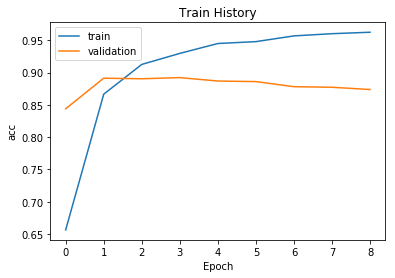

In [25]:
show_train_history(model_history,'acc','val_acc')

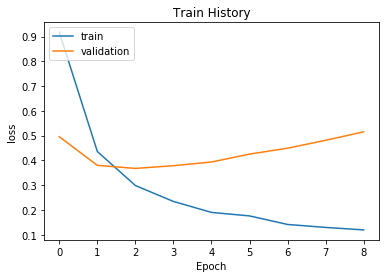

In [26]:
show_train_history(model_history,'loss','val_loss')

In [27]:
def to_cat_name(x): 
        return mapping[x]
    
def predict(test):
#     model = load_model(model_path)
    y_predict_probability = model.predict(test)
    y_predict = model.predict_classes(test)

    return to_cat_name(y_predict), y_predict, y_predict_probability

def predict_class(data):
    y_predict_probability = model.predict(data, batch_size=64, verbose=1)
    predict_arr = []
    predictClass = []
    for row in y_predict_probability: 
            classIndex=0
            selectClass=0
            selectProbability=0
            for item in row: 
                #print(float(item))
                if(selectProbability <= float(item)):
                    #print(classIndex)
                    selectProbability=float(item)
                    selectClass=classIndex
                classIndex=classIndex+1
            predictClass.append(selectClass)
            
    return to_cat_name(predictClass),predictClass,y_predict_probability

y_predict_name, y_predict, y_predict_probability = predict_class(x_val)

2850/2850 [==============================] - 0s 98us/step


In [28]:
answer_name = to_cat_name(y_val)

In [29]:
#model.predict_classes(x_val)

In [30]:
x_val

array([[   0,    0,    0, ...,  652,  379,   10],
       [   0,    0,    0, ..., 4838, 2040,  221],
       [   0,    0,    0, ...,   68,  123,  387],
       ...,
       [   0,    0,    0, ..., 4423,    5,   22],
       [   0,    0,    0, ..., 1931,   69, 1317],
       [   0,    0,    0, ...,  122,  975, 1023]], dtype=int32)

In [31]:
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [32]:
# model.predict(x_val)

In [33]:
# predict_df = pd.DataFrame({'1_sentence':df_test.sentence,
#               '2_y_predict':y_predict,
#               '3_y_predict_name':y_predict_name,
#               '4_answer':df_test.target,
#               '5_y_predict_probability':list(y_predict_probability)})
# predict_df

In [34]:
predict_df = pd.DataFrame({
              '1_sentence':X_val,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':y_val,
              '5_answer_name':answer_name,
              '6_y_predict_probability':list(y_predict_probability)})
# predict_df

In [35]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['2_y_predict'] != predict_df['4_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.8989473684210526 !!!!!!!!


In [36]:
differ_ans=predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]
differ_ans

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
1333,"win10t,系統,跳出,視窗,要求,更新,不確,確定,更新,",0,Outlook與郵件,3,網路,"[0.56256634, 0.13076718, 0.051199686, 0.045748..."
11704,"收發,發郵件,郵件,設定,問題",0,Outlook與郵件,3,網路,"[0.99996483, 1.8303284e-07, 1.991589e-05, 9.83..."
588,"vpn,連上,進一步,一步,進入,bpm,sap,連不上,不上",1,SAP,3,網路,"[3.2556058e-05, 0.792153, 0.001592321, 0.20463..."
13588,"printer,列印",1,SAP,3,網路,"[0.004464807, 0.96046454, 0.011231634, 0.00869..."
12604,"bpm,申請,名片,問題",3,網路,4,資訊系統,"[0.032036453, 0.2253987, 0.1391932, 0.4438664,..."
9560,"每次,進入,入會,出現,同步,資料,資料夾,發生,生錯,錯誤,84b9560",1,SAP,0,Outlook與郵件,"[0.03851062, 0.8113364, 0.051756565, 0.0401033..."
5596,"桌面,右下,右下角,下角,區域,連線,顯示,嘗試,試驗,驗證,網路,對內,對外,都可,請問,...",2,其他,3,網路,"[0.000273289, 6.183681e-05, 0.64824337, 0.3508..."
13250,"使用,avl,功能,輸入,廣達,帶出",4,資訊系統,1,SAP,"[0.11622155, 0.15198493, 0.05077607, 0.0844349..."
13132,"wordpad,法開,開啓",4,資訊系統,2,其他,"[0.12394005, 0.14994101, 0.106742345, 0.182334..."
1270,"myquanta,bpm",4,資訊系統,3,網路,"[0.027405955, 0.07134705, 0.063795365, 0.34787..."


In [37]:
# confusion matrix
pd.crosstab(np.array(y_predict_name), np.array(answer_name),
            rownames=['predict'], colnames=['answer'])

answer,Outlook與郵件,SAP,其他,網路,資訊系統
predict,,,,,
Outlook與郵件,775,7,15,16,7
SAP,9,318,12,24,18
其他,10,6,144,21,9
網路,18,10,34,1098,29
資訊系統,7,12,14,10,227


In [38]:

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
# loaded_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test, verbose=0)
# print(score)

In [39]:
pd.DataFrame(differ_ans).to_csv('CNN_v4.csv')